# Random Forest Classification

@author: Florian Beyer

Version: 0.3

Datum: 2020-05-07

Classification using Random Forest

Updates: 
- generating a report.txt with all outputs
- using all cores to improve processing time


The script is based on the classification script of Chris Holden:
SOURCE: http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

additional things added/integrated:
- independend validation
- exception handling for memory error during the prediction part
- shape files as input (Julien Rebetez https://github.com/terrai/rastercube/blob/master/rastercube/datasources/shputils.py)
- report.txt


### Section - Required packages

In [21]:
# packages

import os
gdal_data_path = 'C:/ProgramData/miniconda3/envs/GIStools/Library/share/gdal'
os.environ['GDAL_DATA'] = gdal_data_path
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import seaborn as sn

import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()


### Section - Input data

- This is the only section where you have to change something.

In [22]:

# define a number of trees that should be used (default = 500)
est = 300

# how many cores should be used?
# -1 -> all available cores
n_cores = -1

# training tile
img_RS = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 12 Grid\Inputs\Inputs_Automated\Grid_38\stacked_bands_output.tif"

#prediction tile
img_LS = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 12 Grid\Inputs\Inputs_Automated\Grid_15\stacked_bands_output.tif"
# training and validation as shape files
training = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Training.shp"
validation = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Validation.shp"

# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'id'


# directory, where the classification image should be saved:
classification_image = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 12 Grid\Results\Results_Automated\ME_RF_Classified.tif"

# directory, where the all meta results should be saved:
results_txt = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 12 Grid\Results\Results_Automated\ME_RF_Results.txt"

In [23]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['fid', 'id', 'layer', 'path']


### Section - Data preparation

In [24]:
# prepare results text file:

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


In [25]:
# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()


In [26]:



row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))


Image extent: 16931 x 16931 (row x col)
Number of Bands: 6


In [27]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()



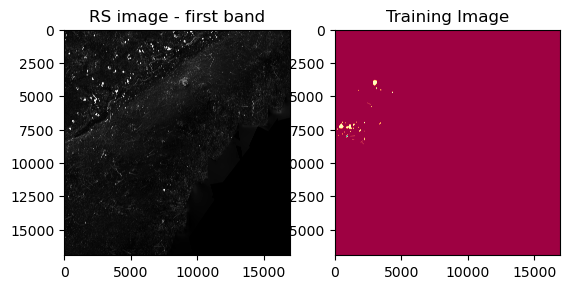

374402 training samples
training data include 2 classes: [1 2]
Our X matrix is sized: (374402, 6)
Our y array is sized: (374402,)


In [28]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

### Section - Train Random Forest

In [29]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)



# verbose = 2 -> prints out every tree progression
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


### Section - RF Model Diagnostics

In [30]:
# With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))


# we can show the band importance:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))

    
# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

OOB prediction of accuracy is: 95.63276905572086%
Band 1 importance: 0.4018742448229601
Band 2 importance: 0.27058800183293574
Band 3 importance: 0.08968080512741809
Band 4 importance: 0.07237278748439281
Band 5 importance: 0.08089024891917004
Band 6 importance: 0.08459391181312322


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s


predict       1      2     All
truth                         
1        332762      0  332762
2             0  41640   41640
All      332762  41640  374402


[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished


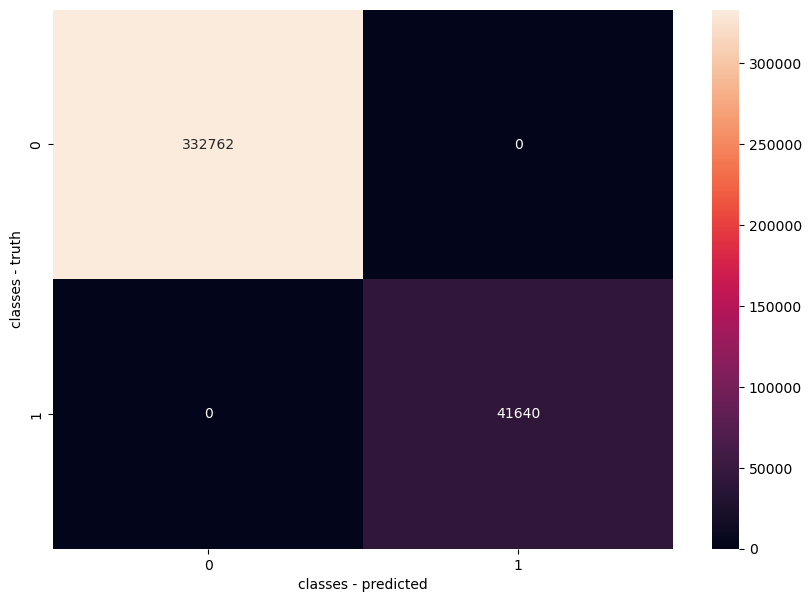

In [31]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

### Section - Prediction

In [32]:
# Predicting the rest of the image

img_ls = gdal.Open(img_LS, gdal.GA_ReadOnly)

img = np.zeros((img_ls.RasterYSize, img_ls.RasterXSize, img_ls.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ls.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ls.GetRasterBand(b + 1).ReadAsArray()

row = img_ls.RasterYSize
col = img_ls.RasterXSize
band_number = img_ls.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)


Image extent: 16931 x 16931 (row x col)
Number of Bands: 6
Reshaped from (16931, 16931, 6) to (286658761, 6)


In [33]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round((len(img_as_array)/2)))
    print("Slices: ", slices)
    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, slices: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = round(slices/2)
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Slices:  143329380
Not enought RAM, new slices = 71664690


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Not enought RAM, new slices = 35832345
Not enought RAM, new slices = 17916172
Not enought RAM, new slices = 8958086
Not enought RAM, new slices = 4479043
Not enought RAM, new slices = 2239522
Not enought RAM, new slices = 1119761


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Not enought RAM, new slices = 559880


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.19531236305036564 %, slices: 559880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.3906247261007313 %, slices: 1119760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.585937089151097 %, slices: 1679640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.7812494522014626 %, slices: 2239520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


0.9765618152518283 %, slices: 2799400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.171874178302194 %, slices: 3359280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.3671865413525597 %, slices: 3919160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.5624989044029252 %, slices: 4479040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.7578112674532909 %, slices: 5038920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


1.9531236305036566 %, slices: 5598800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.1484359935540223 %, slices: 6158680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.343748356604388 %, slices: 6718560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.5390607196547537 %, slices: 7278440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    4.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.7343730827051194 %, slices: 7838320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    2.9s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    5.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


2.929685445755485 %, slices: 8398200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    3.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.1249978088058503 %, slices: 8958080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.320310171856216 %, slices: 9517960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.5156225349065817 %, slices: 10077840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.7109348979569474 %, slices: 10637720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


3.906247261007313 %, slices: 11197600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.101559624057678 %, slices: 11757480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.2968719871080445 %, slices: 12317360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.49218435015841 %, slices: 12877240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.687496713208776 %, slices: 13437120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


4.882809076259141 %, slices: 13997000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.078121439309507 %, slices: 14556880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.273433802359873 %, slices: 15116760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.468746165410239 %, slices: 15676640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.664058528460604 %, slices: 16236520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


5.85937089151097 %, slices: 16796400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.054683254561335 %, slices: 17356280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.249995617611701 %, slices: 17916160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.445307980662067 %, slices: 18476040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.640620343712432 %, slices: 19035920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


6.835932706762798 %, slices: 19595800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.031245069813163 %, slices: 20155680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.22655743286353 %, slices: 20715560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.421869795913895 %, slices: 21275440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.617182158964261 %, slices: 21835320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


7.812494522014626 %, slices: 22395200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.007806885064992 %, slices: 22955080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.203119248115357 %, slices: 23514960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.398431611165723 %, slices: 24074840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.593743974216089 %, slices: 24634720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.789056337266455 %, slices: 25194600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


8.98436870031682 %, slices: 25754480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.179681063367186 %, slices: 26314360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.374993426417552 %, slices: 26874240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.570305789467918 %, slices: 27434120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.765618152518282 %, slices: 27994000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


9.960930515568649 %, slices: 28553880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.156242878619015 %, slices: 29113760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.351555241669379 %, slices: 29673640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.546867604719745 %, slices: 30233520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.742179967770111 %, slices: 30793400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


10.937492330820477 %, slices: 31353280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.132804693870842 %, slices: 31913160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.328117056921208 %, slices: 32473040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.523429419971574 %, slices: 33032920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.71874178302194 %, slices: 33592800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


11.914054146072305 %, slices: 34152680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.10936650912267 %, slices: 34712560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.304678872173037 %, slices: 35272440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.499991235223401 %, slices: 35832320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.695303598273767 %, slices: 36392200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


12.890615961324134 %, slices: 36952080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.0859283243745 %, slices: 37511960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.281240687424864 %, slices: 38071840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.47655305047523 %, slices: 38631720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.671865413525596 %, slices: 39191600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


13.867177776575963 %, slices: 39751480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.062490139626327 %, slices: 40311360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.257802502676693 %, slices: 40871240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.45311486572706 %, slices: 41431120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.648427228777424 %, slices: 41991000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


14.84373959182779 %, slices: 42550880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.039051954878156 %, slices: 43110760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.234364317928522 %, slices: 43670640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.429676680978886 %, slices: 44230520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.624989044029252 %, slices: 44790400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


15.820301407079619 %, slices: 45350280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.015613770129985 %, slices: 45910160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.21092613318035 %, slices: 46470040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.406238496230714 %, slices: 47029920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.60155085928108 %, slices: 47589800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.796863222331446 %, slices: 48149680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


16.992175585381812 %, slices: 48709560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.187487948432178 %, slices: 49269440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.382800311482544 %, slices: 49829320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.57811267453291 %, slices: 50389200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.773425037583277 %, slices: 50949080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


17.96873740063364 %, slices: 51508960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.164049763684005 %, slices: 52068840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.35936212673437 %, slices: 52628720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.554674489784738 %, slices: 53188600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.749986852835104 %, slices: 53748480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    2.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


18.94529921588547 %, slices: 54308360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.140611578935836 %, slices: 54868240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.3359239419862 %, slices: 55428120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.531236305036565 %, slices: 55988000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.72654866808693 %, slices: 56547880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


19.921861031137297 %, slices: 57107760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.117173394187663 %, slices: 57667640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.31248575723803 %, slices: 58227520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.507798120288395 %, slices: 58787400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.703110483338758 %, slices: 59347280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


20.898422846389124 %, slices: 59907160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.09373520943949 %, slices: 60467040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.289047572489856 %, slices: 61026920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.484359935540223 %, slices: 61586800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.67967229859059 %, slices: 62146680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


21.874984661640955 %, slices: 62706560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.07029702469132 %, slices: 63266440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.265609387741684 %, slices: 63826320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.46092175079205 %, slices: 64386200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.656234113842416 %, slices: 64946080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


22.851546476892782 %, slices: 65505960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.046858839943148 %, slices: 66065840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.242171202993514 %, slices: 66625720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.43748356604388 %, slices: 67185600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.632795929094243 %, slices: 67745480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


23.82810829214461 %, slices: 68305360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.023420655194975 %, slices: 68865240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.21873301824534 %, slices: 69425120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.414045381295708 %, slices: 69985000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.609357744346074 %, slices: 70544880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.80467010739644 %, slices: 71104760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


24.999982470446803 %, slices: 71664640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.19529483349717 %, slices: 72224520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.390607196547535 %, slices: 72784400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.5859195595979 %, slices: 73344280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.781231922648267 %, slices: 73904160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


25.976544285698633 %, slices: 74464040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.171856648749 %, slices: 75023920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.367169011799362 %, slices: 75583800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.562481374849728 %, slices: 76143680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.757793737900094 %, slices: 76703560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


26.95310610095046 %, slices: 77263440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.148418464000827 %, slices: 77823320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.343730827051193 %, slices: 78383200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.53904319010156 %, slices: 78943080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.734355553151925 %, slices: 79502960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


27.929667916202288 %, slices: 80062840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.124980279252654 %, slices: 80622720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.32029264230302 %, slices: 81182600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.515605005353386 %, slices: 81742480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.710917368403752 %, slices: 82302360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


28.90622973145412 %, slices: 82862240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.101542094504484 %, slices: 83422120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.296854457554847 %, slices: 83982000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.492166820605213 %, slices: 84541880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.68747918365558 %, slices: 85101760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


29.882791546705946 %, slices: 85661640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.07810390975631 %, slices: 86221520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.273416272806678 %, slices: 86781400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.468728635857044 %, slices: 87341280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.664040998907407 %, slices: 87901160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


30.859353361957773 %, slices: 88461040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.05466572500814 %, slices: 89020920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.249978088058505 %, slices: 89580800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.44529045110887 %, slices: 90140680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.640602814159237 %, slices: 90700560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


31.835915177209603 %, slices: 91260440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.03122754025997 %, slices: 91820320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.22653990331033 %, slices: 92380200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.4218522663607 %, slices: 92940080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.617164629411064 %, slices: 93499960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


32.81247699246143 %, slices: 94059840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.0077893555118 %, slices: 94619720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.20310171856216 %, slices: 95179600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.39841408161253 %, slices: 95739480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.59372644466289 %, slices: 96299360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.78903880771326 %, slices: 96859240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


33.984351170763624 %, slices: 97419120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.179663533813994 %, slices: 97979000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.374975896864356 %, slices: 98538880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.57028825991472 %, slices: 99098760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.76560062296509 %, slices: 99658640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


34.96091298601545 %, slices: 100218520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.15622534906582 %, slices: 100778400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.35153771211618 %, slices: 101338280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.54685007516655 %, slices: 101898160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.742162438216916 %, slices: 102458040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


35.93747480126728 %, slices: 103017920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.13278716431765 %, slices: 103577800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.32809952736801 %, slices: 104137680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.52341189041838 %, slices: 104697560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.71872425346874 %, slices: 105257440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


36.91403661651911 %, slices: 105817320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.109348979569475 %, slices: 106377200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.30466134261984 %, slices: 106937080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.49997370567021 %, slices: 107496960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.69528606872057 %, slices: 108056840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


37.89059843177094 %, slices: 108616720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.0859107948213 %, slices: 109176600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.28122315787167 %, slices: 109736480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.476535520922035 %, slices: 110296360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.6718478839724 %, slices: 110856240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


38.86716024702277 %, slices: 111416120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.06247261007313 %, slices: 111976000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.2577849731235 %, slices: 112535880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.45309733617386 %, slices: 113095760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.64840969922423 %, slices: 113655640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


39.843722062274594 %, slices: 114215520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.03903442532496 %, slices: 114775400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.234346788375326 %, slices: 115335280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.42965915142569 %, slices: 115895160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.62497151447606 %, slices: 116455040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


40.82028387752642 %, slices: 117014920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.01559624057679 %, slices: 117574800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.21090860362715 %, slices: 118134680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.406220966677516 %, slices: 118694560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.601533329727886 %, slices: 119254440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.79684569277825 %, slices: 119814320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


41.99215805582862 %, slices: 120374200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.18747041887898 %, slices: 120934080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.38278278192935 %, slices: 121493960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.57809514497971 %, slices: 122053840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.773407508030076 %, slices: 122613720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


42.968719871080445 %, slices: 123173600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.16403223413081 %, slices: 123733480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.35934459718118 %, slices: 124293360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.55465696023154 %, slices: 124853240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.74996932328191 %, slices: 125413120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


43.94528168633227 %, slices: 125973000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.14059404938264 %, slices: 126532880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.335906412433005 %, slices: 127092760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.53121877548337 %, slices: 127652640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.72653113853374 %, slices: 128212520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


44.9218435015841 %, slices: 128772400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.11715586463447 %, slices: 129332280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.31246822768483 %, slices: 129892160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.5077805907352 %, slices: 130452040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.703092953785564 %, slices: 131011920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


45.89840531683593 %, slices: 131571800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.093717679886296 %, slices: 132131680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.28903004293666 %, slices: 132691560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.48434240598703 %, slices: 133251440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.67965476903739 %, slices: 133811320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


46.87496713208776 %, slices: 134371200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.070279495138124 %, slices: 134931080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.265591858188486 %, slices: 135490960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.460904221238856 %, slices: 136050840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.65621658428922 %, slices: 136610720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


47.85152894733959 %, slices: 137170600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.04684131038995 %, slices: 137730480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.24215367344032 %, slices: 138290360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.43746603649068 %, slices: 138850240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.632778399541046 %, slices: 139410120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


48.828090762591415 %, slices: 139970000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.02340312564178 %, slices: 140529880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.21871548869215 %, slices: 141089760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.41402785174251 %, slices: 141649640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.60934021479288 %, slices: 142209520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.80465257784324 %, slices: 142769400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


49.999964940893605 %, slices: 143329280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.195277303943975 %, slices: 143889160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.39058966699434 %, slices: 144449040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.58590203004471 %, slices: 145008920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.78121439309507 %, slices: 145568800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


50.97652675614544 %, slices: 146128680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.1718391191958 %, slices: 146688560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.367151482246165 %, slices: 147248440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.562463845296534 %, slices: 147808320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.7577762083469 %, slices: 148368200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


51.95308857139727 %, slices: 148928080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.14840093444763 %, slices: 149487960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.343713297498 %, slices: 150047840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.53902566054836 %, slices: 150607720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.734338023598724 %, slices: 151167600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


52.929650386649094 %, slices: 151727480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.124962749699456 %, slices: 152287360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.320275112749826 %, slices: 152847240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.51558747580019 %, slices: 153407120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.71089983885056 %, slices: 153967000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


53.90621220190092 %, slices: 154526880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.10152456495129 %, slices: 155086760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.29683692800165 %, slices: 155646640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.492149291052016 %, slices: 156206520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.687461654102385 %, slices: 156766400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


54.88277401715275 %, slices: 157326280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.07808638020312 %, slices: 157886160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.27339874325348 %, slices: 158446040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.46871110630385 %, slices: 159005920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.66402346935421 %, slices: 159565800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


55.859335832404575 %, slices: 160125680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.054648195454945 %, slices: 160685560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.24996055850531 %, slices: 161245440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.44527292155568 %, slices: 161805320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.64058528460604 %, slices: 162365200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


56.83589764765641 %, slices: 162925080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.03121001070677 %, slices: 163484960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.226522373757135 %, slices: 164044840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.421834736807504 %, slices: 164604720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.61714709985787 %, slices: 165164600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


57.81245946290824 %, slices: 165724480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.0077718259586 %, slices: 166284360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.20308418900897 %, slices: 166844240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.39839655205933 %, slices: 167404120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.593708915109694 %, slices: 167964000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.789021278160064 %, slices: 168523880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


58.984333641210426 %, slices: 169083760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.179646004260796 %, slices: 169643640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.37495836731116 %, slices: 170203520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.57027073036153 %, slices: 170763400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.76558309341189 %, slices: 171323280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


59.960895456462254 %, slices: 171883160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.15620781951262 %, slices: 172443040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.351520182562986 %, slices: 173002920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.546832545613356 %, slices: 173562800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.74214490866372 %, slices: 174122680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


60.93745727171409 %, slices: 174682560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.13276963476445 %, slices: 175242440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.32808199781481 %, slices: 175802320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.52339436086518 %, slices: 176362200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.718706723915545 %, slices: 176922080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


61.914019086965915 %, slices: 177481960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.10933145001628 %, slices: 178041840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.30464381306665 %, slices: 178601720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.49995617611701 %, slices: 179161600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.69526853916738 %, slices: 179721480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


62.89058090221774 %, slices: 180281360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.085893265268105 %, slices: 180841240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.281205628318475 %, slices: 181401120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.47651799136884 %, slices: 181961000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.67183035441921 %, slices: 182520880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


63.86714271746957 %, slices: 183080760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.06245508051994 %, slices: 183640640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.2577674435703 %, slices: 184200520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.45307980662066 %, slices: 184760400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.64839216967103 %, slices: 185320280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


64.8437045327214 %, slices: 185880160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.03901689577177 %, slices: 186440040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.23432925882213 %, slices: 186999920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.42964162187249 %, slices: 187559800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.62495398492285 %, slices: 188119680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


65.82026634797323 %, slices: 188679560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.0155787110236 %, slices: 189239440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.21089107407396 %, slices: 189799320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.40620343712432 %, slices: 190359200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.6015158001747 %, slices: 190919080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.79682816322506 %, slices: 191478960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


66.99214052627542 %, slices: 192038840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.18745288932578 %, slices: 192598720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.38276525237615 %, slices: 193158600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.57807761542652 %, slices: 193718480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.77338997847689 %, slices: 194278360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


67.96870234152725 %, slices: 194838240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.16401470457761 %, slices: 195398120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.35932706762799 %, slices: 195958000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.55463943067835 %, slices: 196517880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.74995179372871 %, slices: 197077760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


68.94526415677907 %, slices: 197637640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.14057651982944 %, slices: 198197520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.33588888287981 %, slices: 198757400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.53120124593018 %, slices: 199317280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.72651360898054 %, slices: 199877160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


69.9218259720309 %, slices: 200437040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.11713833508126 %, slices: 200996920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.31245069813164 %, slices: 201556800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.507763061182 %, slices: 202116680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.70307542423237 %, slices: 202676560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


70.89838778728273 %, slices: 203236440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.0937001503331 %, slices: 203796320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.28901251338347 %, slices: 204356200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.48432487643383 %, slices: 204916080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.6796372394842 %, slices: 205475960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


71.87494960253456 %, slices: 206035840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.07026196558493 %, slices: 206595720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.2655743286353 %, slices: 207155600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.46088669168566 %, slices: 207715480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.65619905473602 %, slices: 208275360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


72.85151141778638 %, slices: 208835240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.04682378083676 %, slices: 209395120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.24213614388712 %, slices: 209955000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.43744850693749 %, slices: 210514880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.63276086998785 %, slices: 211074760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


73.82807323303822 %, slices: 211634640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.02338559608859 %, slices: 212194520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.21869795913895 %, slices: 212754400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.41401032218931 %, slices: 213314280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.60932268523968 %, slices: 213874160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.80463504829005 %, slices: 214434040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


74.99994741134041 %, slices: 214993920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.19525977439078 %, slices: 215553800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.39057213744114 %, slices: 216113680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.5858845004915 %, slices: 216673560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.78119686354188 %, slices: 217233440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


75.97650922659224 %, slices: 217793320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.1718215896426 %, slices: 218353200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.36713395269297 %, slices: 218913080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.56244631574334 %, slices: 219472960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.7577586787937 %, slices: 220032840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


76.95307104184407 %, slices: 220592720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.14838340489443 %, slices: 221152600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.3436957679448 %, slices: 221712480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.53900813099517 %, slices: 222272360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.73432049404553 %, slices: 222832240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


77.9296328570959 %, slices: 223392120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.12494522014626 %, slices: 223952000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.32025758319664 %, slices: 224511880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.515569946247 %, slices: 225071760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.71088230929736 %, slices: 225631640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


78.90619467234772 %, slices: 226191520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.10150703539809 %, slices: 226751400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.29681939844846 %, slices: 227311280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.49213176149883 %, slices: 227871160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.68744412454919 %, slices: 228431040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


79.88275648759955 %, slices: 228990920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.07806885064991 %, slices: 229550800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.27338121370029 %, slices: 230110680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.46869357675065 %, slices: 230670560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.66400593980102 %, slices: 231230440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


80.85931830285138 %, slices: 231790320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.05463066590175 %, slices: 232350200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.24994302895212 %, slices: 232910080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.44525539200248 %, slices: 233469960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.64056775505284 %, slices: 234029840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


81.8358801181032 %, slices: 234589720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.03119248115358 %, slices: 235149600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.22650484420394 %, slices: 235709480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.4218172072543 %, slices: 236269360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.61712957030467 %, slices: 236829240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


82.81244193335503 %, slices: 237389120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.00775429640541 %, slices: 237949000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.20306665945577 %, slices: 238508880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.39837902250613 %, slices: 239068760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.5936913855565 %, slices: 239628640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.78900374860687 %, slices: 240188520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


83.98431611165724 %, slices: 240748400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.1796284747076 %, slices: 241308280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.37494083775796 %, slices: 241868160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.57025320080832 %, slices: 242428040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.7655655638587 %, slices: 242987920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


84.96087792690906 %, slices: 243547800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.15619028995943 %, slices: 244107680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.35150265300979 %, slices: 244667560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.54681501606015 %, slices: 245227440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.74212737911053 %, slices: 245787320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


85.93743974216089 %, slices: 246347200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.13275210521125 %, slices: 246907080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.32806446826162 %, slices: 247466960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.52337683131199 %, slices: 248026840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.71868919436236 %, slices: 248586720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


86.91400155741272 %, slices: 249146600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.10931392046308 %, slices: 249706480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.30462628351344 %, slices: 250266360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.49993864656382 %, slices: 250826240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.69525100961418 %, slices: 251386120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


87.89056337266454 %, slices: 251946000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.08587573571491 %, slices: 252505880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.28118809876528 %, slices: 253065760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.47650046181565 %, slices: 253625640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.67181282486601 %, slices: 254185520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


88.86712518791637 %, slices: 254745400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.06243755096673 %, slices: 255305280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.25774991401711 %, slices: 255865160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.45306227706747 %, slices: 256425040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.64837464011784 %, slices: 256984920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


89.8436870031682 %, slices: 257544800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.03899936621856 %, slices: 258104680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.23431172926894 %, slices: 258664560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.4296240923193 %, slices: 259224440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.62493645536966 %, slices: 259784320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


90.82024881842003 %, slices: 260344200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.0155611814704 %, slices: 260904080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.21087354452077 %, slices: 261463960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.40618590757113 %, slices: 262023840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.60149827062149 %, slices: 262583720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.79681063367185 %, slices: 263143600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


91.99212299672223 %, slices: 263703480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.18743535977259 %, slices: 264263360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.38274772282296 %, slices: 264823240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.57806008587332 %, slices: 265383120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.77337244892368 %, slices: 265943000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


92.96868481197406 %, slices: 266502880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.16399717502442 %, slices: 267062760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.35930953807478 %, slices: 267622640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.55462190112515 %, slices: 268182520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.74993426417552 %, slices: 268742400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


93.94524662722588 %, slices: 269302280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.14055899027625 %, slices: 269862160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.33587135332661 %, slices: 270422040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.53118371637697 %, slices: 270981920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.72649607942735 %, slices: 271541800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


94.92180844247771 %, slices: 272101680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.11712080552807 %, slices: 272661560


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.31243316857844 %, slices: 273221440


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.5077455316288 %, slices: 273781320


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.70305789467918 %, slices: 274341200


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


95.89837025772954 %, slices: 274901080


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.0936826207799 %, slices: 275460960


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.28899498383026 %, slices: 276020840


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.48430734688064 %, slices: 276580720


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.679619709931 %, slices: 277140600


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


96.87493207298137 %, slices: 277700480


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.07024443603173 %, slices: 278260360


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.26555679908209 %, slices: 278820240


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.46086916213247 %, slices: 279380120


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.65618152518283 %, slices: 279940000


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


97.8514938882332 %, slices: 280499880


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.04680625128356 %, slices: 281059760


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.24211861433393 %, slices: 281619640


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.4374309773843 %, slices: 282179520


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.63274334043466 %, slices: 282739400


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


98.82805570348502 %, slices: 283299280


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.02336806653538 %, slices: 283859160


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.21868042958576 %, slices: 284419040


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.41399279263612 %, slices: 284978920


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.60930515568649 %, slices: 285538800


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


99.80461751873685 %, slices: 286098680


[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s


99.99992988178721 %, slices: 286658560


[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished


In [34]:
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))


Reshaped back to (16931, 16931)


### Section - Masking

- Mask classification image (black border = 0)


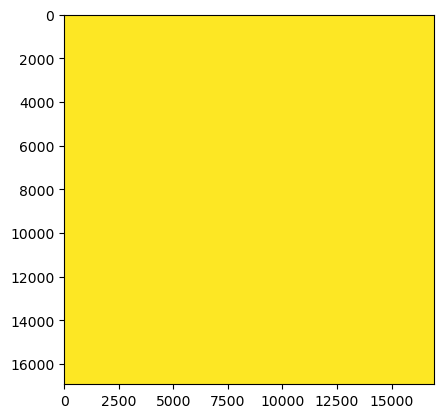

In [35]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

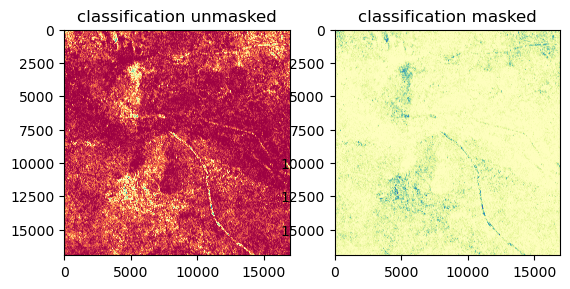

In [36]:
# mask classification an plot

class_prediction.astype(np.float16)
class_prediction_ = class_prediction*mask

plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

### Section - Saving Classification Image to disk

In [37]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction_.astype(np.float16)
driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(classification_image))

Image saved to: Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 12 Grid\Results\Results_Automated\ME_RF_Classified.tif


### Section - Accuracy Assessment

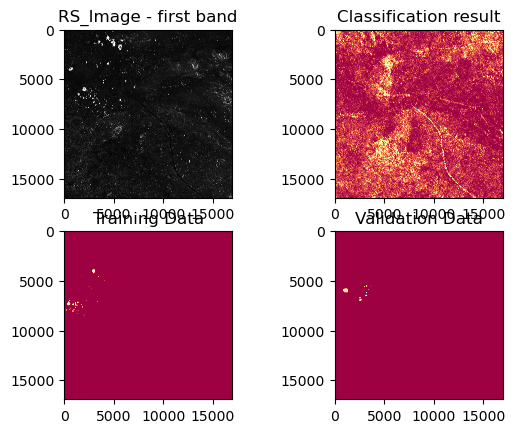

284536 validation pixels
validation data include 2 classes: [1 2]
Our X matrix is sized: (284536,)
Our y array is sized: (284536,)
col_0       1     2     All
row_0                      
1      219512  6049  225561
2       55838  3137   58975
All    275350  9186  284536
              precision    recall  f1-score   support

           1       0.80      0.97      0.88    225561
           2       0.34      0.05      0.09     58975

    accuracy                           0.78    284536
   macro avg       0.57      0.51      0.48    284536
weighted avg       0.70      0.78      0.71    284536

OAA = 78.24985239126157 %


In [38]:
# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('Classification result')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)
plt.title('Validation Data')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} validation pixels'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

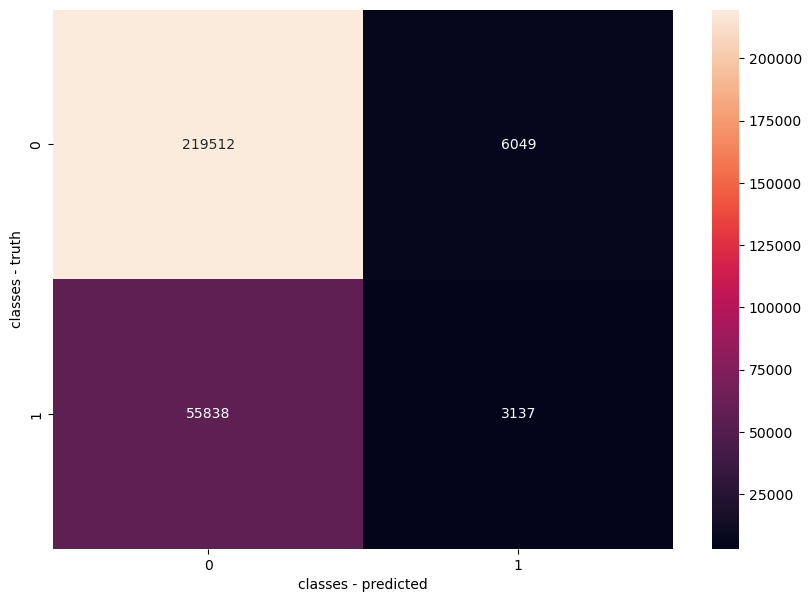

In [39]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()